# 3DVar with Lorenz’63
## Pavitra Chandarana, Jan Stüwe

In this notebook, we apply three‐dimensional variational data assimilation to the chaotic Lorenz’63 model using synthetic noisy observations. We enhance the classical 3DVar analysis with a neural‐network–based correction of the analysis increments and assess performance via RMSE and phase‐space diagnostics under different observational settings. Our results demonstrate the promise of hybrid variational–machine learning methods for improving state estimation in low‐dimensional chaotic systems.

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import warnings
from typing import Callable, Dict

import plotly.graph_objects as go
import torch
from torch import nn

SEED = 42   # Setting a random seed for reproducibility
np.random.seed(SEED)
torch.manual_seed(SEED)

warnings. filterwarnings("ignore", category=Warning)                

The Lorenz ’63 system is a classic example of a low-dimensional chaotic dynamical system, governed by the equations:


\begin{aligned}
\dot{x} &= \sigma\,(y - x),\\
\dot{y} &= x\,(\rho - z) - y,\\
\dot{z} &= x\,y - \beta\,z,
\end{aligned}


where the parameters are set to $\sigma = 10, \rho = 28, \beta = \frac{8}{3}.
$

We will now:

1. Integrate the Lorenz equations from $t=0$ to $t=T$ using SciPy’s adaptive RK45 solver with a fixed maximum step size $\Delta t$.
2. Visualize the resulting 3D trajectory.

**Integration settings**:

- Time span: $0 \le t \le T$, with $T = 200$  
- Time step for output: $\Delta t = 0.01$
- Number of steps: $n_{\text{steps}} = T / \Delta t$  
- Initial condition: $\mathbf{x}_0 = [1.0,\,1.0,\,1.0]$

In [2]:
σ = 10.0  
ρ = 28.0    
β = 8.0 / 3.0
dt = 0.01  

def lorenz63(x):
    x1, x2, x3 = x
    return np.array([
        σ * (x2 - x1),         
        x1 * (ρ - x3) - x2,   
        x1 * x2 - β * x3       
    ])

def rk4_step(x, f, h):
    """
    One classical 4th-order Runge–Kutta step for numerical integration.
    
    RK4 is a high-accuracy method that evaluates the derivative at four points
    within each time step to achieve O(h^4) local truncation error.
    
    Args:
        x: Current state vector
        f: Function that computes derivatives (dx/dt = f(x))
        h: Step size
    Returns:
        Next state vector after one time step
    """
    k1 = f(x)                    # Slope at beginning of interval
    k2 = f(x + 0.5 * h * k1)     # Slope at midpoint using k1
    k3 = f(x + 0.5 * h * k2)     # Slope at midpoint using k2
    k4 = f(x + h * k3)           # Slope at end using k3
                                 # Weighted average of slopes: 1/6(k1 + 2k2 + 2k3 + k4)
    return x + (h / 6.0) * (k1 + 2*k2 + 2*k3 + k4)

def integrate(x0, n_steps, h=dt):
    """
    Integrate a single trajectory from initial condition x0.
    
    Uses RK4 to evolve the Lorenz system forward in time, storing
    the state at each time step for analysis and visualization.
    
    Args:
        x0: Initial condition [x(0), y(0), z(0)]
        n_steps: Number of time steps to integrate
        h: Time step size (default: dt = 0.01)
    Returns:
        Array of shape (n_steps+1, 3) containing the full trajectory
    """
    xs = np.empty((n_steps + 1, 3))  # Pre-allocate trajectory array
    xs[0] = x0                       # Store initial condition
    x = x0.copy()                    # Working copy to avoid modifying x0
    
    # Integrate forward using RK4
    for i in range(1, n_steps + 1):
        x = rk4_step(x, lorenz63, h)
        xs[i] = x                    # Store state at each time step
    return xs

def batch_integrate(x0_batch, n_steps, h=dt):
    """
    Integrate many initial conditions in parallel.
    
    Useful for ensemble runs, sensitivity studies, and generating
    training data for machine learning models.
    
    Args:
        x0_batch: Array of initial conditions, shape (n_ic, 3)
        n_steps: Number of time steps for each trajectory
        h: Time step size
    Returns:
        Array of shape (n_ic, n_steps+1, 3) containing all trajectories
    """
    return np.stack([integrate(x0, n_steps, h) for x0 in x0_batch])

The next step is to conduct a "nature run". We again integrate from $0 \leq T \leq 200$ with the given parameters.

Furthermore, we add a so called "stride" to save every second oberservation. In other words, we make observation with $\Delta t_{ \text{obs}} = 0.02$ and add some $\varepsilon \sim \mathcal{N}(0, 1)$.

Observe that our model state space and observation space have the same dimension, so we use 
$$ H:= \begin{pmatrix}
1 & 0 & 0 \\
0 & 1 & 0 \\
0 & 0 & 1
\end{pmatrix}.$$

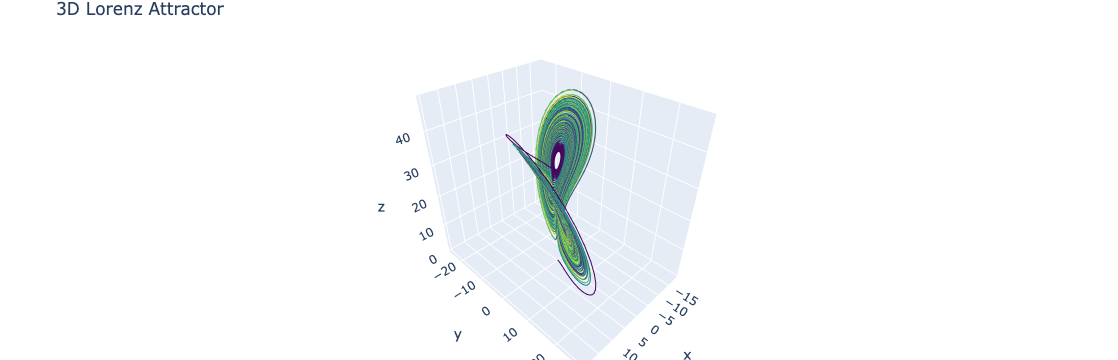

In [3]:
T = 200.0   # Simulating for T = 200 (instructed in problem setting)
n_truth = int(T / dt)    
x0_truth = np.array([1.0, 1.0, 1.0])    # True X observation
org_time = np.linspace(0, 200, 20001)

truth = integrate(x0_truth, n_truth) 

stride = 2
obs_times_idx = np.arange(0, truth.shape[0], stride)
obs_times = obs_times_idx * dt

obs_noise_std = 1
H = np.eye(3)      # LINEAR OPERATOR H
y_obs = truth[obs_times_idx] + np.random.normal(0, obs_noise_std, size=(len(obs_times_idx), 3))

trace = go.Scatter3d(
    x=truth[:, 0], y=truth[:, 1], z=truth[:, 2],
    mode="lines",
    line=dict(
        width=2,
        color=org_time,
        colorscale="Viridis"
    )
)

layout = go.Layout(
    title="3D Lorenz Attractor",
    scene=dict(
        xaxis=dict(title="x"),
        yaxis=dict(title="y"),
        zaxis=dict(title="z"),
    ),
    margin=dict(l=0, r=0, b=0, t=30)
)

fig = go.Figure(data=[trace], layout=layout)

fig.show()

We can observe the typical Lorenz behaviour with the two attractors where the trajectories spin around. If the initial value is only slightly pertubed, it will create drastically different trajectories. This is why the Lorenz system is a chaotic system.

## Task 1: Compute RMSE between multiple Lorenz runs + Construction of $B$
We compute one "ground-truth" Lorenz'63 run. Afterwards we run 20 more, compute the RMSE to the groundtruth and take the mean.

In [4]:
N_ens = 200                          
x0_ens = np.random.uniform(-20, 20, size=(N_ens, 3)) 
free_runs = batch_integrate(x0_ens, n_truth)      

ens_mean = free_runs.mean(axis=0)                     
sq_err   = (free_runs - ens_mean[None, :, :])**2
rmse_t   = np.sqrt(sq_err.mean(axis=(0, 2)))        

X_prime = free_runs[:, -1, :] - free_runs[:, -1, :].mean(axis=0)
B = X_prime.T @ X_prime / (N_ens - 1)

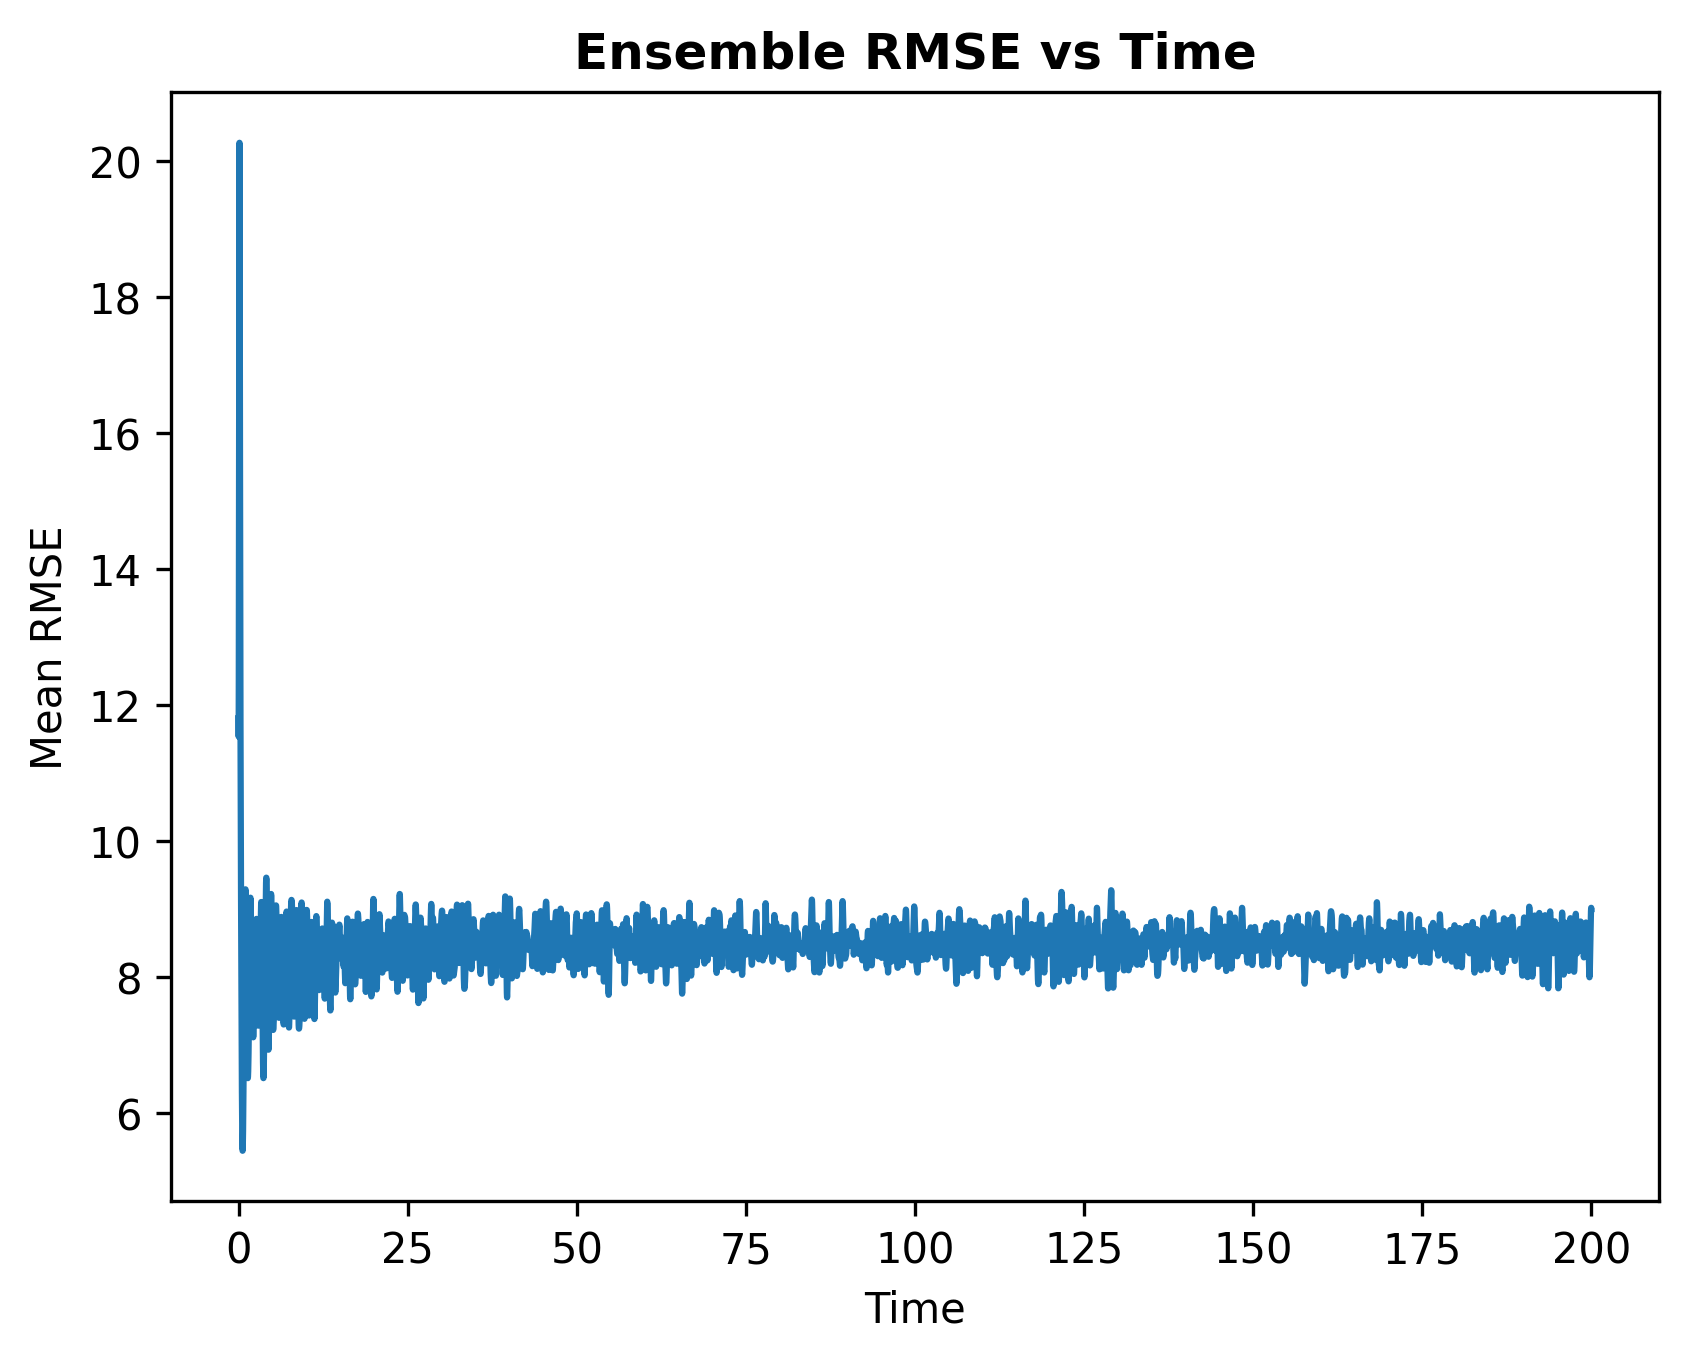

In [5]:
plt.figure(dpi=300)
plt.plot(org_time, rmse_t)
plt.xlabel("Time")
plt.ylabel("Mean RMSE")
plt.title("Ensemble RMSE vs Time", fontweight="bold")
plt.show()

We can observe a drastic spike at $t \approx 0$. This is expected, because we uniformly sample the initial values from $A := \left[ -20, 20 \right]^3$ with $diam(A) = 40 \sqrt{3}$. Thus, the RMSE for the initial values will be rather large before the trajectories begin their spirals.


As the next step, we will use this enemble of Lorenz runs to estimate the Background Covariance $B$. 

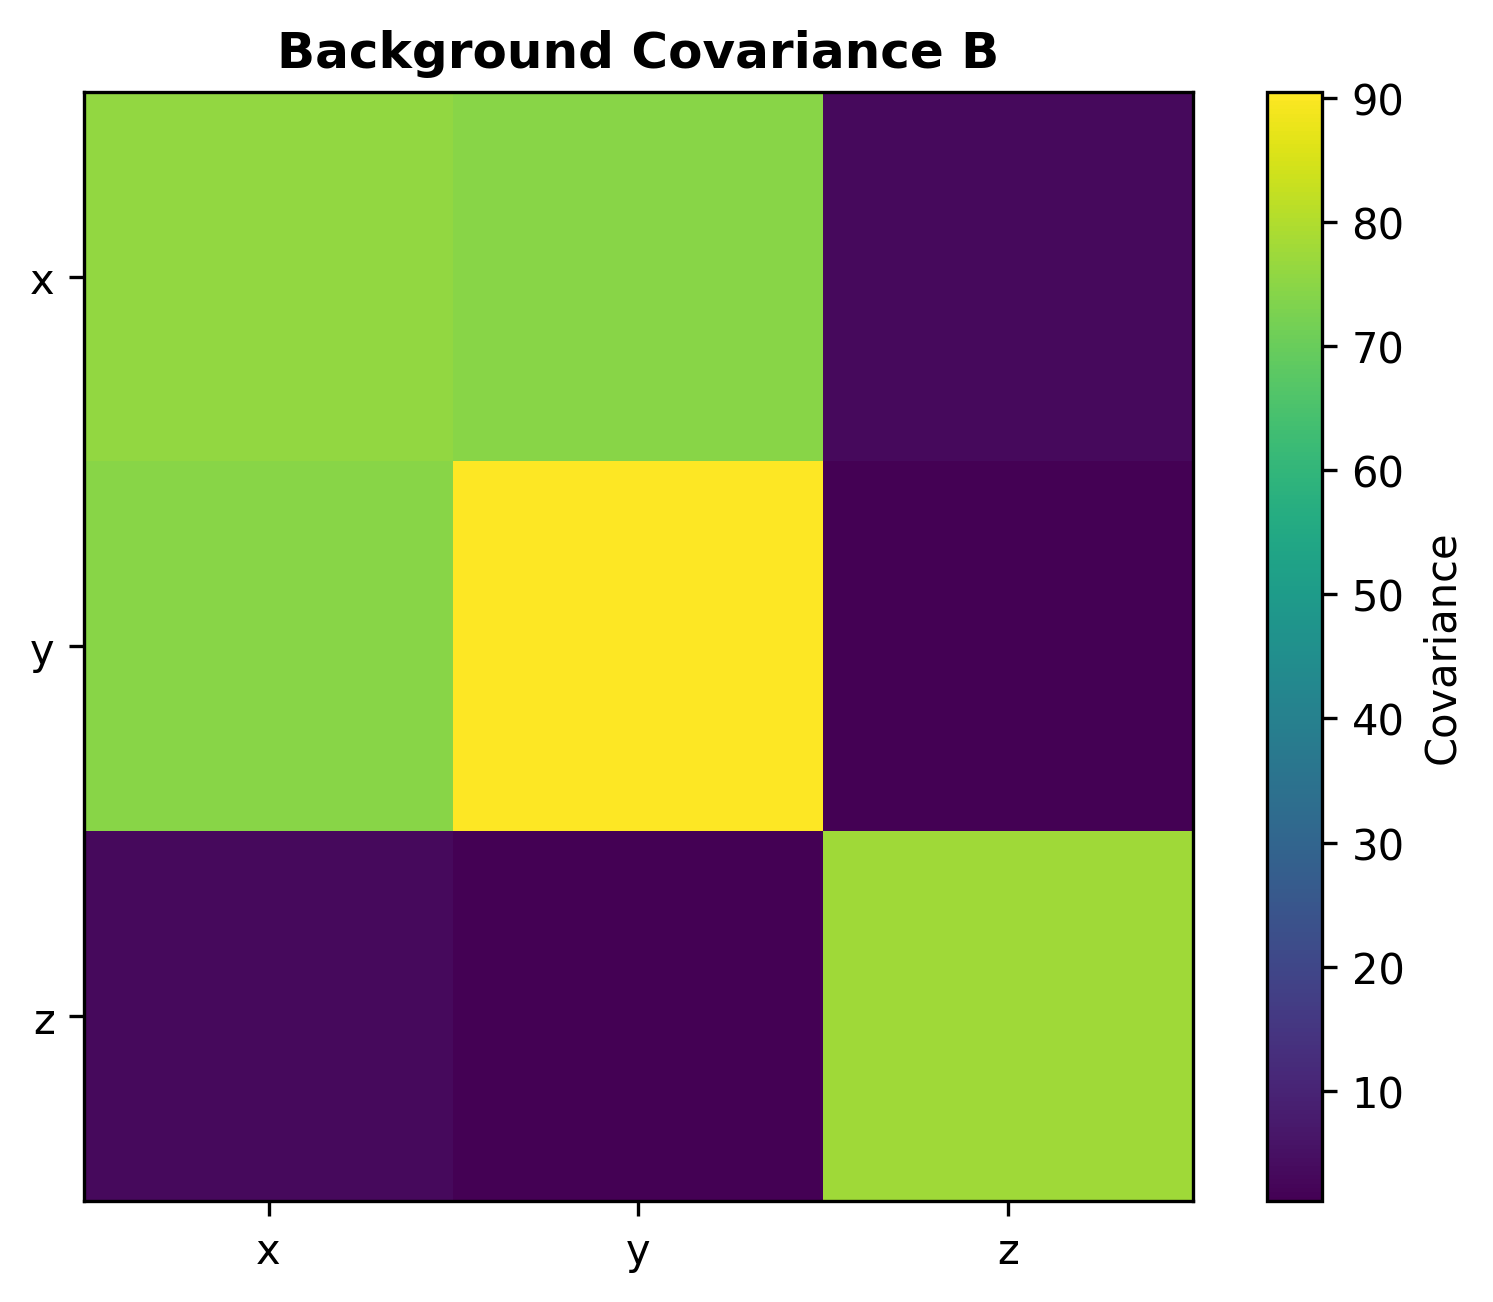

In [6]:
plt.figure(dpi=300)
plt.imshow(B, cmap="viridis", interpolation="none")
plt.colorbar(label="Covariance")
plt.title("Background Covariance B", fontweight="bold")
plt.xticks([0,1,2], ["x","y","z"])
plt.yticks([0,1,2], ["x","y","z"])
plt.show()

In [7]:
B

array([[75.99041731, 74.75456654,  3.26490685],
       [74.75456654, 90.45546824,  1.14147516],
       [ 3.26490685,  1.14147516, 77.88117152]])

It can also be noted that this is indeed a covariance matrix, as it is positive semi-definite.

# Twin Experiment

The next step is to implement 3DVar. We will compute the Kalman Gain $K$ and determine the "classical" increment $x_t - x_b$. These increments will later be used to train a neural net on. We store all innovations, increments and values for later use.

In [8]:
R = (obs_noise_std**2) * np.eye(3)          # observation-error covariance
R_inv = np.linalg.inv(R)
K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)  # constant Kalman gain (static B)
print("3D-Var Kalman gain K:\n", K)

def assimilate_3dvar(x0_b, obs_times_idx, y_obs):
    """Return arrays of analysis and background trajectories."""
    x_b = x0_b.copy()
    x_b_series = []
    x_a_series = []
    innovations = []
    incs = []

    for k, obs_idx in enumerate(obs_times_idx):
        steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b = integrate(x_b, steps_ahead)[-1]

        d = y_obs[k] - H @ x_b
        x_a = x_b + K @ d

        innovations.append(d)
        incs.append(x_a - x_b)
        x_b_series.append(x_b.copy())
        x_a_series.append(x_a.copy())

        x_b = x_a

    return (np.array(x_b_series), np.array(x_a_series),
            np.array(innovations), np.array(incs))

x_b_series, x_a_series, d_series, inc_series = assimilate_3dvar(
    x0_b=np.array([-8.0, 7.0, 27.0]),    # deliberately wrong initial guess
    obs_times_idx=obs_times_idx,
    y_obs=y_obs
)

3D-Var Kalman gain K:
 [[ 0.93678094  0.05165115  0.00186921]
 [ 0.05165115  0.94686379 -0.00136893]
 [ 0.00186921 -0.00136893  0.98726515]]


We will now construct the feature matrix, which consists of the $x_b$ values and the noisy observations. The target variable is the known truth minus $x_b$. We make an $80 / 20$ train-test split and train a neural network with three hidden layers, and use Adam as the optimizer.

In [9]:
train_frac = 0.8
n_cycles   = len(obs_times_idx)
n_train    = int(train_frac * n_cycles)

X_feat = np.hstack([
    x_b_series,    
    y_obs     
])                    

truth_at_obs = truth[obs_times_idx]    
y_target = truth_at_obs - x_b_series     

X_train = torch.tensor(X_feat[:n_train], dtype=torch.float32)
y_train = torch.tensor(y_target[:n_train], dtype=torch.float32)
X_val   = torch.tensor(X_feat[n_train:], dtype=torch.float32)
y_val   = torch.tensor(y_target[n_train:], dtype=torch.float32)

mlp = nn.Sequential(
    nn.Linear(6, 64), nn.ReLU(),
    nn.Linear(64, 64), nn.ReLU(),
    nn.Linear(64, 32), nn.ReLU(),
    nn.Linear(32, 16), nn.ReLU(),
    nn.Linear(16, 3)
)

optimizer = torch.optim.Adam(mlp.parameters(), lr=1e-3)
loss_fn   = nn.MSELoss()

best_val = float("inf")
patience = 50
wait     = 0

for epoch in range(1000):
    mlp.train()
    optimizer.zero_grad()
    loss = loss_fn(mlp(X_train), y_train)
    loss.backward(); optimizer.step()

    mlp.eval()
    with torch.no_grad():
        val_loss = loss_fn(mlp(X_val), y_val).item()

    if val_loss < best_val - 1e-5:
        best_val = val_loss
        wait = 0
    else:
        wait += 1
        if wait > patience:
            print(f"Early-stopping at epoch {epoch}")
            break

print("Best validation MSE:", best_val)
mlp.eval()

Best validation MSE: 0.35682597756385803


Sequential(
  (0): Linear(in_features=6, out_features=64, bias=True)
  (1): ReLU()
  (2): Linear(in_features=64, out_features=64, bias=True)
  (3): ReLU()
  (4): Linear(in_features=64, out_features=32, bias=True)
  (5): ReLU()
  (6): Linear(in_features=32, out_features=16, bias=True)
  (7): ReLU()
  (8): Linear(in_features=16, out_features=3, bias=True)
)

We observe an RMSE of $0.36$. It is now left to combine the Neural Network estimates with 3DVar.

In [10]:
d_mat = np.array(d_series)      
d_mean = d_mat.mean(axis=0)
print("Mean innovation μ_d:", d_mean)

S_hat = (d_mat - d_mean).T @ (d_mat - d_mean) / (d_mat.shape[0] - 1)
S_theo = H @ B @ H.T + R
print("\nSample innovation cov Ŝ:\n", S_hat)
print("\nTheoretical S = HBH^T + R:\n", S_theo)

fro_norm = np.linalg.norm(S_hat - S_theo, ord="fro")
print("\nFrobenius norm |Ŝ - S|_F =", fro_norm)

Mean innovation μ_d: [-0.0005913   0.00285226 -0.0010175 ]

Sample innovation cov Ŝ:
 [[ 1.68120344  0.26124689 -0.05432747]
 [ 0.26124689  1.91992019  0.02494185]
 [-0.05432747  0.02494185  1.95668217]]

Theoretical S = HBH^T + R:
 [[76.99041731 74.75456654  3.26490685]
 [74.75456654 91.45546824  1.14147516]
 [ 3.26490685  1.14147516 78.88117152]]

Frobenius norm |Ŝ - S|_F = 175.29548308187026


In [11]:
x_b  = np.array([-8.0, 7.0, 27.0])  # same bad start
rmse_ml = []
rmse_3d = []

for k, obs_idx in enumerate(obs_times_idx):
    steps_ahead = obs_idx - (0 if k == 0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]

    d = y_obs[k] - H @ x_b
    δ_3d = K @ d

    feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
    δ_ml = mlp(feat).detach().numpy()

    x_a_3d = x_b + δ_3d
    x_a_ml = x_b + δ_ml

    err = np.linalg.norm(x_a_3d - truth[obs_idx])
    rmse_3d.append(err)

    err = np.linalg.norm(x_a_ml - truth[obs_idx])
    rmse_ml.append(err)
    
    x_b = x_a_3d

print("ML mean RMSE:", np.mean(rmse_ml))
print("3D mean RMSE:", np.mean(rmse_3d))

ML mean RMSE: 0.9272451508623617
3D mean RMSE: 1.5273683883742664


In [12]:
def run_cycle(x0: np.ndarray,
              gain: Callable[[np.ndarray, np.ndarray], np.ndarray],
              label: str) -> Dict[str, np.ndarray]:
    x_b  = x0.copy()
    b_hist, a_hist, rmse_hist = [], [], []

    for k, idx in enumerate(obs_times_idx):
        steps = idx - (0 if k == 0 else obs_times_idx[k-1])
        x_b   = integrate(x_b, steps)[-1]

        x_a   = gain(x_b, y_obs[k])

        b_hist.append(x_b)
        a_hist.append(x_a)
        rmse_hist.append(np.linalg.norm(x_a - truth[idx]))

        x_b = x_a

    return {"label": label,
            "x_b":  np.vstack(b_hist),
            "x_a":  np.vstack(a_hist),
            "rmse": np.array(rmse_hist)}


def classic_gain(x_b, y_k):
    d = y_k - H @ x_b    
    return x_b + K @ d          


def ml_gain(x_b, y_k):
    feat  = torch.tensor(np.hstack([x_b, y_k]), dtype=torch.float32)
    δ_ml  = mlp(feat).detach().numpy()        # neural-net increment
    return x_b + δ_ml                         # x_a = x_b + δ̂_ml

        Method  Mean RMSE  Median RMSE  Min (best)
        3D-Var     1.5274       1.4724      0.0105
Predicted-Incr     0.7780       0.7265      0.0368


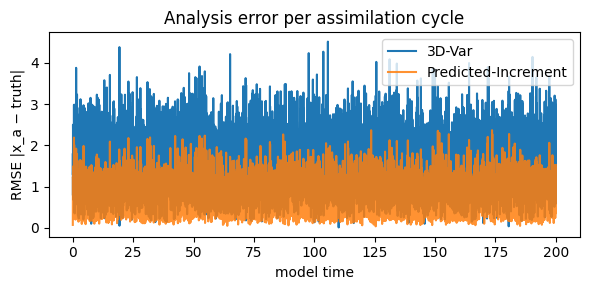

In [ ]:
x0_bad = np.array([-8.0, 7.0, 27.0])      # same poor starting guess

standard  = run_cycle(x0_bad, classic_gain, label="3D-Var")
pred_inc  = run_cycle(x0_bad, ml_gain    , label="Predicted-Incr")

summary = pd.DataFrame({
    "Method":        [standard["label"], pred_inc["label"]],
    "Mean RMSE":     [standard["rmse"].mean(), pred_inc["rmse"].mean()],
    "Median RMSE":   [np.median(standard["rmse"]), np.median(pred_inc["rmse"])],
    "Min (best)":    [standard["rmse"].min(), pred_inc["rmse"].min()]
})
print(summary.to_string(index=False, float_format="%.4f"))

t = obs_times_idx * dt
plt.figure(figsize=(6,3), dpi=300)
plt.plot(t, standard["rmse"], label="3D-Var")
plt.plot(t, pred_inc["rmse"], label="Predicted-Increment", alpha=0.85)
plt.xlabel("model time"); plt.ylabel("RMSE |x_a − truth|")
plt.title("Analysis error per assimilation cycle", fontweight="bold")
plt.legend(); plt.tight_layout()
plt.show()

In [18]:
def run_experiment(R_scalar):
    R = (R_scalar**2) * np.eye(3)
    y_obs = truth[obs_times_idx] + np.random.normal(0, R_scalar, size=(len(obs_times_idx), 3))
    K = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)
    x_b = np.array([-8.0, 7.0, 27.0])
    rmse = []
    for k, obs_idx in enumerate(obs_times_idx):
        steps_ahead = obs_idx - (0 if k==0 else obs_times_idx[k-1])
        x_b = integrate(x_b, steps_ahead)[-1]

        feat = torch.tensor(np.hstack([x_b, y_obs[k]]), dtype=torch.float32)
        δ_ml = mlp(feat).detach().numpy()
        x_a = x_b + δ_ml
        rmse.append(np.linalg.norm(x_a - truth[obs_idx]))
        x_b = x_a
    return np.mean(rmse)


def monte_carlo_run_experiment(R_scalar, num_trials=100):
    rmse_list = []
    for _ in range(num_trials):
        rmse = run_experiment(R_scalar)
        rmse_list.append(rmse)
    return np.mean(rmse_list), np.std(rmse_list)

for σ_r in [1.0,  np.sqrt(2.0),  np.sqrt(5.0)]:
    mean_rmse, std_rmse = monte_carlo_run_experiment(σ_r, num_trials=100)
    print(f"R variance = {σ_r**2:.1f}  → mean RMSE = {mean_rmse:.3f} ± {std_rmse:.3f}")

R variance = 1.0  → mean RMSE = 0.796 ± 0.005
R variance = 2.0  → mean RMSE = 1.094 ± 0.006
R variance = 5.0  → mean RMSE = 1.700 ± 0.010


Method      3D-Var  Hybrid  PredInc
R variance                         
1           1.5281  1.0980   0.7928
2           2.0901  1.5260   1.0959
5           3.0774  2.3014   1.6934


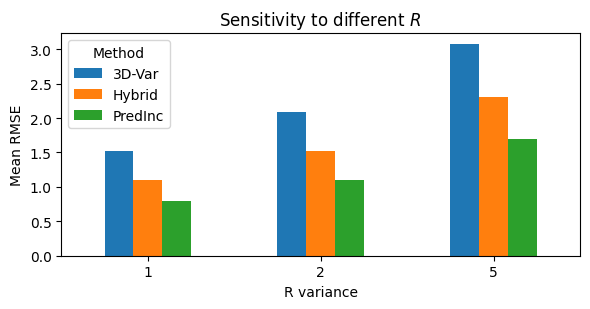

In [ ]:
sigma_list = [1.0, np.sqrt(2.0), np.sqrt(5.0)]   # std ⇒ variances = 1, 2, 5
w_blend    = 0.5                                 # same hybrid weight as before
x0_bad     = np.array([-8.0, 7.0, 27.0])         # identical poor start

records = []

for sigma_r in sigma_list:
    R = (sigma_r**2) * np.eye(3)
    y_obs = truth[obs_times_idx] + np.random.normal(0, sigma_r, size=(len(obs_times_idx), 3))
    
    K_var = B @ H.T @ np.linalg.inv(H @ B @ H.T + R)

    def classic_gain_var(x_b, y_k, K=K_var):
        d = y_k - H @ x_b
        return x_b + K @ d

    def hybrid_gain_var(x_b, y_k, K=K_var):
        d    = y_k - H @ x_b
        δ_3d = K @ d
        δ_ml = mlp(torch.tensor(np.hstack([x_b, y_k]), dtype=torch.float32)).detach().numpy()
        return x_b + w_blend * δ_3d + (1 - w_blend) * δ_ml

    res_std   = run_cycle(x0_bad, classic_gain_var, label="3D-Var")
    res_ml    = run_cycle(x0_bad, ml_gain,          label="PredInc")       #  δ̂_ml only
    res_hyb   = run_cycle(x0_bad, hybrid_gain_var,  label="Hybrid")

    for res in (res_std, res_ml, res_hyb):
        records.append({
            "R variance": round(sigma_r**2),
            "Method":     res["label"],
            "Mean RMSE":  res["rmse"].mean()
        })

df = pd.DataFrame(records)
print(df.pivot(index="R variance", columns="Method", values="Mean RMSE").round(4))

ax = df.pivot(index="R variance", columns="Method", values="Mean RMSE").plot(
        kind="bar", figsize=(6,3.2), rot=0)
ax.set_ylabel("Mean RMSE")
ax.set_title("Sensitivity to different $R$", fontweight="bold")
plt.gcf().set_dpi(300)
plt.tight_layout(); 
plt.show()

In [16]:
K

array([[ 0.93678094,  0.05165115,  0.00186921],
       [ 0.05165115,  0.94686379, -0.00136893],
       [ 0.00186921, -0.00136893,  0.98726515]])

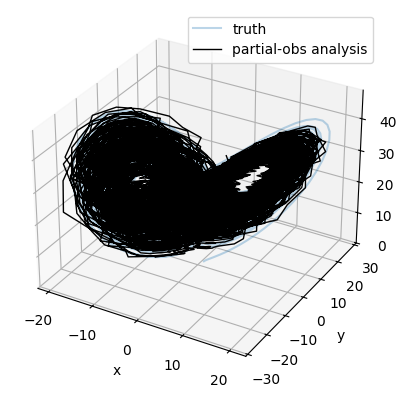

In [17]:
H_partial = np.array([[1.0, 0.0, 0.0]])   # 1×3
R_scalar  = obs_noise_std**2
R_partial = np.array([[R_scalar]])
y_obs = truth[obs_times_idx] + np.random.normal(0, R_scalar, size=(len(obs_times_idx), 3))

K_partial = B @ H_partial.T @ np.linalg.inv(H_partial @ B @ H_partial.T + R_partial)

x_b = np.array([-8.0, 7.0, 27.0])
x_a_store = []

for k, obs_idx in enumerate(obs_times_idx):
    steps_ahead = obs_idx - (0 if k==0 else obs_times_idx[k-1])
    x_b = integrate(x_b, steps_ahead)[-1]
    d   = y_obs[k, :1] - H_partial @ x_b       
    x_a = x_b + (K_partial @ d).flatten()
    x_a_store.append(x_a)
    x_b = x_a

x_a_store = np.array(x_a_store)

fig = plt.figure(figsize=(5,4))
ax = fig.add_subplot(projection='3d')
ax.plot(*truth.T, alpha=0.3, label='truth')
ax.plot(*x_a_store.T, color='k', lw=1, label='partial-obs analysis')
ax.set_xlabel('x'); ax.set_ylabel('y'); ax.set_zlabel('z')
ax.legend(); plt.tight_layout()
plt.show()